# Школа глубокого обучения

<a href="https://mipt.ru/science/labs/laboratoriya-neyronnykh-sistem-i-glubokogo-obucheniya/"><img align="right" src="https://avatars1.githubusercontent.com/u/29918795?v=4&s=200" alt="DeepHackLab" style="position:relative;top:-40px;right:10px;height:100px;" /></a>



### Физтех-Школа Прикладной математики и информатики МФТИ 
### Лаборатория нейронных сетей и глубокого обучения (DeepHackLab)
*Дедлайн -- 31 декабря.*

*Хахулин Тарас (ФРТК МФТИ)*

Всем привет!
В этом домашнем задании вам предстоит применить знания современного фреймворка для работы с нейронными сетями Pytorch к задаче классфикации картинок.
Мы будем использоваться датасет Cifar10.

### Немного о разбалловке

Домашнее задание номер 7 состоит из двух частей - первая часть - это этот ноутбук, вторая часть - ноутбук по Transfer Learning, лежащий в этой же папке. Суммарно за оба ноутбука можно набрать 20 баллов. Точные критерии оценивания первой части задания установить сложно, поскольку она в большой степени творческая. Во втором задании указана разбалловка.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

import os
import argparse

import matplotlib.pyplot as plt
import numpy as np

import math
from tqdm import tqdm_notebook, tqdm

## Данные:  cifar10

Для начала стоит разобраться, что у нас за датасет

[cifar10](https://www.cs.toronto.edu/~kriz/cifar.html) состоит из 10 классов картинок: самолет, автомобиль, птица, кошка, олень, собака, лягушка, лошадь, корабль, грузовик.

Изображения в CIFAR-10 имеют размер 3x32x32, т.e. nтрехканальные цветные изображения размером 32x32 пикселя.

In [2]:
print('Preparing data.')
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

Preparing data.


Сейчас мы скачаем необходимый датасет в папку data. Для этих целей в torchvision есть удобный функционал.

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=20, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим что же мы скачали

In [4]:
classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)

GroundTruth:       cat     ship     ship    plane


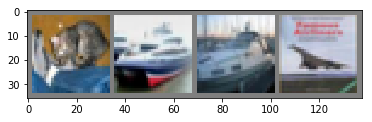

In [5]:
%matplotlib inline
def imshow(img):
    """Show img"""
    img = img
    npimg = img.numpy()/2 + 0.5
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(testloader)
images, labels = dataiter.next() 
# show images and labels
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%8s' % classes[labels[j]] for j in range(4)))

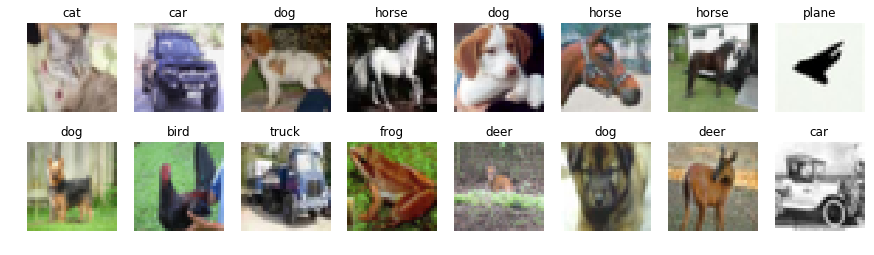

Process Process-8:
Process Process-5:
Traceback (most recent call last):
Process Process-7:
Process Process-6:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tor

In [6]:
# more images
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))

dataiter = iter(testloader)
images, labels = dataiter.next() 
images2, labels2 = dataiter.next()
labels = torch.cat((labels, labels2))
images = torch.cat((images, images2))
for i in range(cols):
    images, labels = dataiter.next()
    for j in range(rows):
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        imshow(images[j])
        ax.set_title(i)
        ax.set_title(classes[labels[j]])
plt.show()

###  Решение задачи классификаиции сверточными сетями

Основная задача построить классификатор, который будет понимать что изображено на картинке.

In [7]:
def accuracy(out, labels):
    _, pred= torch.max(out.data, 1)
    return (pred == labels).sum() / labels.size(0)

Ниже предлагается реализовать простейшую сверточную сеть. Пример архитектуры с параметрами представлен ниже.

In [8]:
class Simple_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 5, padding=1, stride=2),   # <conv2d (5, pad 1, stride 2) out=64>
            nn.BatchNorm2d(64),                         # <batch norm>
            nn.ReLU(),                                  # <relu>
            nn.MaxPool2d(2),                            # <maxpool>
            # add analogical layer
            nn.Conv2d(64, 127, 5, padding=1, stride=2), # <conv2d (5, pad 1, stride 2) out=127>
            nn.BatchNorm2d(127),                        # <batch norm>
            nn.ReLU(),                                  # <relu>
            nn.MaxPool2d(2),                            # <maxpool>
        )
        self.classifier = nn.Sequential(
            nn.Linear(127, 10)                          # <linear layer:shape in view>
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view((-1, 127))
        x = self.classifier(x)
        return x

Теперь будем тренировать нашу сеть. Количество эпох необходимое для обучения( не забывайте про overfit) требуется подобрать самому, как и learning rate. Также рекомендуется рисовать кривые обучения с помощью сохраняемых данных.

In [9]:
import matplotlib.pyplot as plt
from IPython import display
from os.path import exists

In [10]:
def train(trainloader, testloader, reuse=False, skip_learning=False):
    N = len(trainloader)
    print('Length of trainset: {}'.format(N))
    print('Length of testset: {}'.format(len(testloader)))

    # create model
    cnn = Simple_CNN()
    if reuse and exists('save/simple_cnn.pth'):
        cnn.load_state_dict(torch.load('save/simple_cnn.pth'))
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters())

    # train
    loss_history = []
    epochs = 2
    if not skip_learning:
        for epoch in range(epochs):
            loss_sum = 0
            for i, (imgs, labels) in enumerate(tqdm(trainloader)):
                imgs, labels = Variable(imgs, requires_grad=False), Variable(labels, requires_grad=False)
                cnn.zero_grad()

                outputs = cnn.forward(imgs)
                loss = criterion(outputs, labels)

                loss.backward()    #<backward>
                optimizer.step()   #<optimizer_step>

                loss_sum += torch.sum(loss.data)

                if (i + 1) % 200 == 0:
                    # <add validation if you want>
                    loss_history.append(loss_sum / 200)
                    loss_sum = 0
                    if reuse:
                        torch.save(cnn.state_dict(), 'save/simple_cnn.pth')
                    display.clear_output()
                    plt.plot([200 * (i+1) for i in range(len(loss_history))], loss_history)
                    plt.title("Loss sum over iterations")
                    plt.show()
    # test accuracy
    cnn.eval()
    correct, total = 0, 0
    for imgs, labels in tqdm(testloader):
        imgs, labels = Variable(imgs), labels
        outputs = cnn(imgs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum()

    print('Accuracy on {} test images: {:.1f}%'.format(total, correct/total * 100))

    # save histories
    np.savetxt('loss_history.csv', loss_history)
    # save models
    if reuse:
        torch.save(cnn.state_dict(), 'save/simple_cnn.pth')
    return cnn # remove if you save model correctly

In [11]:
model = train(trainloader, testloader, reuse=True, skip_learning=True)

  0%|          | 0/2500 [00:00<?, ?it/s]

Length of trainset: 2500
Length of testset: 2500


100%|██████████| 2500/2500 [01:08<00:00, 36.61it/s]


Accuracy on 10000 test images: 68.4%


<small>График так прыгает, так как это не всё обучение -- только несколько последних эпох</small>

---
### Лирическое отступление -- красивая визуализация

In [12]:
# Keep track of correct guesses in a confusion matrix
n_categories = len(classes)
confusion = torch.zeros(n_categories, n_categories)

# Go through a bunch of examples and record which are correctly guessed
for imgs, labels in tqdm(testloader):
    imgs, labels = Variable(imgs), labels
    outputs = model(imgs)
    _, pred = torch.max(outputs.data, 1)
    confusion[labels, pred] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

100%|██████████| 2500/2500 [01:03<00:00, 39.27it/s]


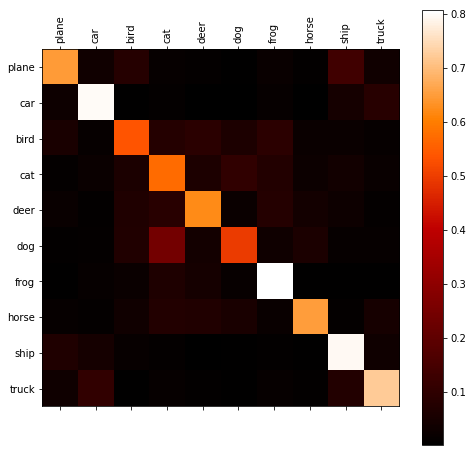

In [15]:
# Set up plot
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy(), cmap="gist_heat")
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels(('',) + classes, rotation=90)
ax.set_yticklabels(('',) + classes)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

GroundTruth:    cat   car plane truck
Predicted:    cat   car plane truck


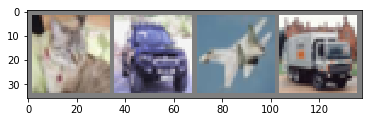

Process Process-19:
Process Process-17:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-18:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-20:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 343, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/pyt

In [16]:
dataiter = iter(testloader)
dataiter.next()
dataiter.next()
images, labels = dataiter.next()

outputs = model(Variable(images))
_, predicted = torch.max(outputs.data, 1)

imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [140]:
def visualize_feature_maps(net, sample):
    net.forward(Variable(sample))
    fig, axes = plt.subplots(2, 12, figsize=(20, 5))
    for i in range(12):
        axes[0, i].imshow(net.features[0].output.data.numpy()[0, i, :, :])
        axes[1, i].imshow(net.features[3].output.data.numpy()[0, i, :, :])
    fig, axes = plt.subplots(2, 12, figsize=(20, 5))
    for i in range(24):
        axes[0, i].imshow(net.features[4].output.data.numpy()[0, i, :, :])
        axes[1, i].imshow(net.features[7].output.data.numpy()[0, i, :, :])
    plt.xticks(tuple())
    plt.yticks(tuple())
    plt.show()

torch.Size([1, 3, 32, 32])


AttributeError: 'Conv2d' object has no attribute 'output'

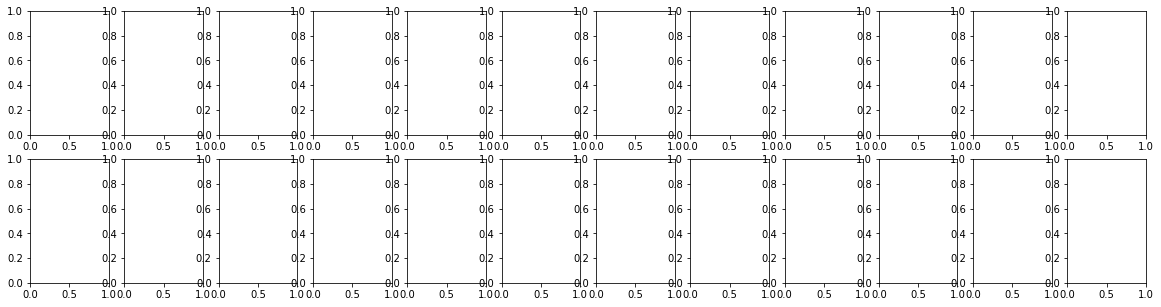

In [141]:
images, labels = dataiter.next()
image = images[0:1, :, :, :]
label = labels[0,]
print(image.shape)
visualize_feature_maps(model, image)

Какой максимальный результат был получен при такой архитектуре?

**Ответ**: 66.9%, что довольно неплохо.

Как бы вы улучшили данную сеть? По итогам последней лекции 

1. Заменил бы _CrossEntropy_ на _CrossEntropyL2_, так как тут стоит задача классификации
2. Увеличил бы количество свёрточных слоёв на 1 или больше
3. Добавил бы Dense + ReLU в конце

На этом задание не заканчивается, как вы видите такая комбинациия двух сверточных слоев не дает достаточного результата. Далее задача становится творческой. Вам предлагается улучшить архитектуру, чтобы увеличить скор (он скорее всего сильно вырастет). 
Используйте инициализацию весов о которой вам рассказывали. 

Инициализировать веса в pytorche можно таким образом(рекомендуется попробовать различные варианты инициализации):

In [83]:
class Simple_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), 
            nn.BatchNorm2d(64),             
            nn.ReLU(),                      
            
            nn.Dropout2d(),
            
            # add analogical layer
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),            
            nn.ReLU(),                      
            
            nn.MaxPool2d(2),
            
            nn.Conv2d(64, 128, 3, padding=1), 
            nn.BatchNorm2d(128),             
            nn.ReLU(),                      
            
            nn.Dropout2d(),
            
            nn.Conv2d(128, 128, 3, padding=1), 
            nn.BatchNorm2d(128),             
            nn.ReLU(),
            
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, 3, padding=1), 
            nn.BatchNorm2d(256),             
            nn.ReLU(),
            
            nn.Dropout2d(),
            
            nn.Conv2d(256, 256, 3, padding=1), 
            nn.BatchNorm2d(128),             
            nn.ReLU(),
            
            nn.Dropout2d(),
            
            nn.Conv2d(256, 256, 3, padding=1), 
            nn.BatchNorm2d(256),             
            nn.ReLU(),
            
            nn.MaxPool2d(2),
            
            nn.Conv2d(256, 512, 3, padding=1), 
            nn.BatchNorm2d(512),             
            nn.ReLU(),
            
            nn.Dropout2d(),
            
            nn.Conv2d(512, 512, 3, padding=1), 
            nn.BatchNorm2d(512),             
            nn.ReLU(),
            
            nn.Dropout2d(),
            
            nn.Conv2d(512, 512, 3, padding=1), 
            nn.BatchNorm2d(512),             
            nn.ReLU(),
            
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512, 10),
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view((-1, 512))
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for seq in (self.features, self.classifier):
            for layer in seq:
                if hasattr(layer, "weight"):
                    nn.init.normal(layer.weight)

In [112]:
def train(trainloader, testloader, reuse=False, skip_learning=False, epochs=2):
    N = len(trainloader)
    
    # create model
    cnn = Better_CNN()
    if reuse and exists('save/better_cnn.pth'):
        cnn.load_state_dict(torch.load('save/better_cnn.pth'))
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters())

    # train
    loss_history = []
    test_history = []
    if not skip_learning:
        for epoch in range(epochs):
            loss_sum = 0
            passed_tests = 0
            for i, (imgs, labels) in enumerate(tqdm(trainloader)):
                imgs, labels = Variable(imgs, requires_grad=False), Variable(labels, requires_grad=False)
                cnn.zero_grad()

                outputs = cnn.forward(imgs)
                loss = criterion(outputs, labels)
                
                loss.backward()    #<backward>
                optimizer.step()   #<optimizer_step>

                loss_sum += torch.sum(loss.data)
                _, pred = torch.max(outputs.data, 1)
                passed_tests += (pred == labels.data).sum()

                if (i + 1) % 200 == 0:
                    # <add validation if you want>
                    loss_history.append(loss_sum / 200)
                    test_history.append(passed_tests / 20 / 200)
                    passed_tests = 0
                    loss_sum = 0
                    if reuse:
                        torch.save(cnn.state_dict(), 'save/better_cnn.pth')
                    display.clear_output()
                    
                    # Two subplots, unpack the axes array immediately
                    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
                    ax1.plot([200 * (i+1) for i in range(len(loss_history))], loss_history)
                    ax1.set_title('Loss')
                    ax2.plot([200 * (i+1) for i in range(len(loss_history))], test_history)
                    ax2.set_title('Accuracy on batches')
                    
                    plt.show()
    # test accuracy
    cnn.eval()
    correct, total = 0, 0
    for imgs, labels in tqdm(testloader):
        imgs, labels = Variable(imgs), labels
        outputs = cnn(imgs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum()

    print('Accuracy on {} test images: {:.1f}%'.format(total, correct/total * 100))

    # save histories
    np.savetxt('loss_history.csv', loss_history)
    # save models
    if reuse:
        torch.save(cnn.state_dict(), 'save/better_cnn.pth')
    return cnn # remove if you save model correctly

In [ ]:
!rm -f save/better_cnn.pth

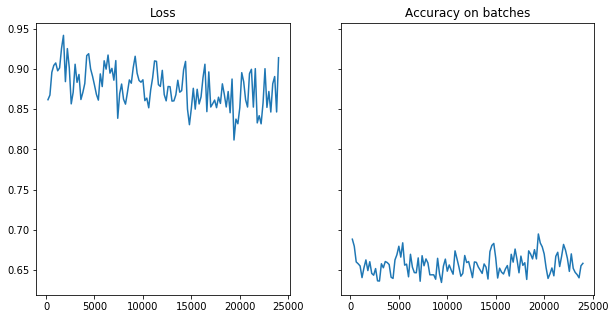

  1%|          | 13/2500 [00:00<03:40, 11.30it/s]

In [ ]:
model = train(trainloader, testloader, reuse=True, epochs=20)

GroundTruth:   frog  frog   car  frog
Predicted:   frog  frog   car  frog


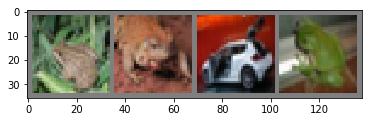

Process Process-109:
Process Process-110:
Process Process-111:
Process Process-112:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/lib/python

In [79]:
dataiter = iter(testloader)
dataiter.next()
images, labels = dataiter.next()

outputs = model(Variable(images))
_, predicted = torch.max(outputs.data, 1)

imshow(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Если хочется еще улучшить качество модели, то можно попробовать реализовать дополнительные архитектуры.

Предлагаемые архитектуры для реализации: vgg11, alexnet, resnet

## Результаты

Я решил реализовать [вот эту сеть](http://torch.ch/blog/2015/07/30/cifar.html).